# Simulations: Monte Carlo analysis and bootstrap methods

Source [here](https://pythonforfinance.net/2019/05/30/python-monte-carlo-vs-bootstrapping/). Amended and corrected for code errors and typos.

In this file, we will compare the concepts of **Monte Carlo analysis** and **Bootstrapping** in relation to simulating returns series and generating corresponding confidence intervals as to a portfolio’s potential risks and rewards.

Both methods are used to generate simulated price paths for a given asset, or portfolio of assets but they use slightly differing methods, which can appear reasonably subtle to those who haven’t come across them before. 
> Technically Bootstrapping is a special case of the Monte Carlo simulation, hence why it may seem a little confusing at first glance.

With Monte Carlo analysis (and here we are talking specifically about the *Parametric* Monte Carlo approach) the idea is to generate data based upon some underlying model characteristics. So for example, we generate data based upon a Normal distribution, specifying our desired inputs to the model, in this case being the mean and the standard deviation. 
> Where do we get these input figures from? More often than not people tend to use values based on the historic, realised values for the assets in question.

So if we were attempting to run some parametric Monte Carlo runs to generate simulated data for say Apply stock, we would tend to measure and calculate the mean and standard deviation of the stocks actual historic returns over a length of time, and use those as inputs to the model. This is one of the weaknesses of this approach, in as much as the model output and corresponding inferences are reliant on the assumption that future returns will display the same characteristics of historic returns (at least those that were used to calculated the model inputs).

**So what is Bootstrapping and how does it differ?** Well Bootstrapping also uses historic returns as a model input, but this time they are used more explicitly. Rather than calculating the underlying characteristics of the returns and then plugging those into a parametric model, we actually generate our data by sampling from the historic return distribution itself.
> It is important to note here that Bootstrapping in involves *replacement* and falls under the notion of a *sampling with replacement* method. 
> That means that when a random sample is extracted from the historic return distribution, it is not “thrown away” and removed from the “hat” as it were, but rather it is replaced and put back in order that it may possibly be chosen again during the following sampling extractions. 
> This is a crucial point to note as it results in a fundamentally different outcome that if one was to “sample without replacement” and each data point were to be removed from the sample once chosen at any point.

The logic behind the Bootstrapping method is that if we use sampling with replacement, then each sample that is drawn, if random, will have the same chance of appearing as it would in “real life” – i.e. as it would in the actual markets for that particular stock (this again relies on the assumption that the future return distribution will retain the same characteristics as the historic return distribution the samples are being drawn from. That is to say both the future and past return distributions are drawn from the same “population”).

So that explanation out of the way, I thought I would collect data for a basket of of assets, create an equally weighted portfolio and then run both parametric Monte Carlo and Bootstrapping simulations, then compare the two results – see how similar of different they end up being!

## The Bootstrap Sampling Method
The basic idea of bootstrap is **make inference about an estimate** (such as sample mean) for a population parameter $\theta$ (such as population mean) on sample data. It is a resampling method by independently sampling with replacement from an existing sample data with same sample size $n$, and performing inference among these resampled data.
> While close form solutions and formulas are available for estimation of sample mean (under some conditions), other estimates may be to complex to get inference (e.g., media, or custom estimators modeled by user).

Generally, bootstrap involves the following steps:

1. A sample from population with sample size $n$.
2. Draw a sample of size $n$ from the original sample **with replacement**, and replicate $B$ times. Each such replicated and re-sampled sample is called a **Bootstrap Sample**, and there will $B$ bootstrap samples in total.
3. Evaluate the statistic of $\theta$ for each Bootstrap Sample. You will end up with $B$ estimates of $\theta$ in total.
    - The statistic you evaluate could be anything (mean, median, mode, correlation, intercept or slope coefficients in OLS regression, Value-at-Risk, etc...
4. Construct a sampling distribution with these $B$ bootstrap statistics and use it to make further statistical inference, such as:
    - Estimating the standard error of $\theta$.
    - Obtaining a Confidence Interval for $\theta$.

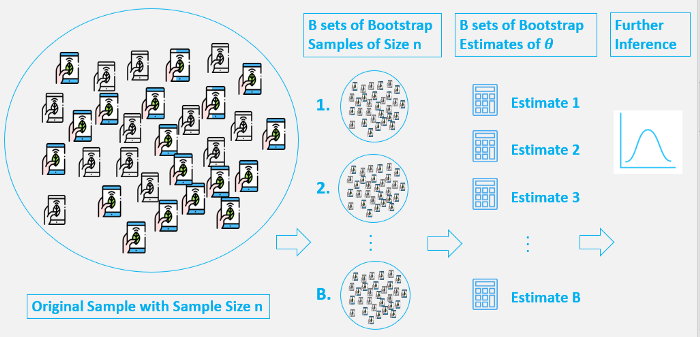

A more specific example:

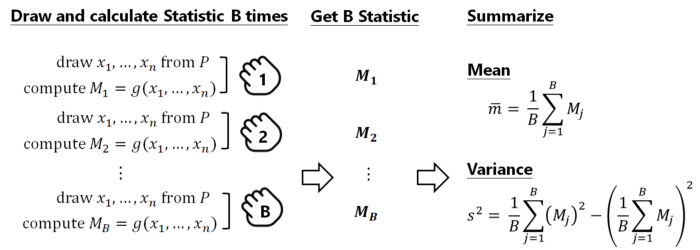................................ 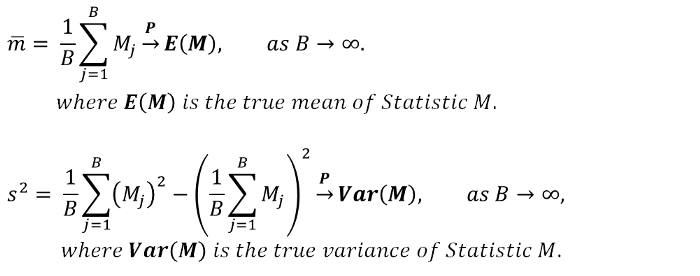


In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import pandas_datareader.data as web
import datetime
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
mpl.style.use('ggplot')
figsize = (15, 8)

Download price data from Yahoo for various stock indices using `pandas_datareader`, and rebase them all to start at 1 for purposes of comparison.

In [2]:
start, end = datetime.datetime(2009, 12, 30), datetime.datetime(2020, 1, 1)
tickers = ["^DJI", "^IXIC", "^GSPC", "^STOXX50E", "^AORD", "^GDAXI"]

asset_universe = pd.DataFrame([web.DataReader(ticker, 'yahoo', start, 
                     end).loc[:, 'Adj Close'] for ticker in tickers],
                     index=tickers).T.fillna(method='ffill')

asset_universe = asset_universe/asset_universe.iloc[0, :]

In [3]:
asset_universe

,^DJI,^IXIC,^GSPC,^STOXX50E,^AORD,^GDAXI
Date,,,,,,
2009-12-29,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2009-12-30,1.000294,1.001259,1.000195,0.991364,1.007365,0.990997
2009-12-31,0.988871,0.991588,0.990144,0.991364,1.007365,0.990997
2010-01-03,0.988871,0.991588,0.990144,0.991364,1.008830,0.990997
2010-01-04,1.003656,1.008748,1.006029,1.008596,1.019084,1.006113
...,...,...,...,...,...,...
2019-12-26,2.714109,3.942663,2.876851,1.262219,1.431050,2.212571
2019-12-27,2.716372,3.935772,2.876949,1.264094,1.431050,2.218581
2019-12-29,2.716372,3.935772,2.876949,1.264094,1.428017,2.218581


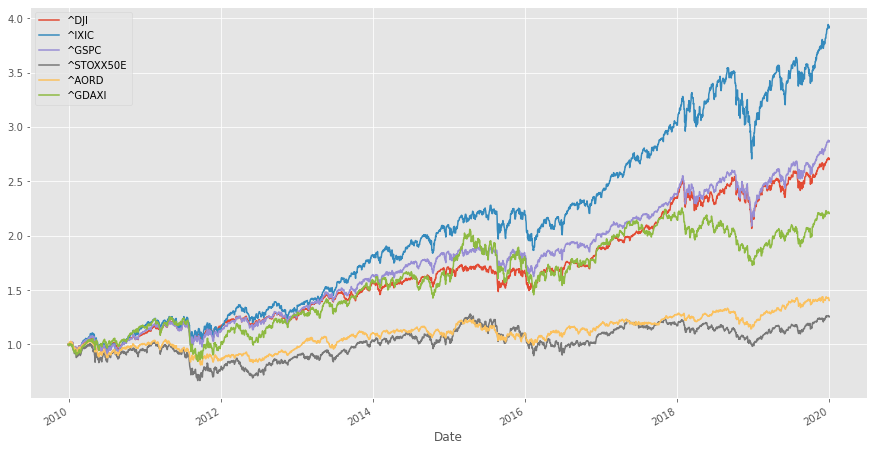

In [4]:
asset_universe.plot(figsize=figsize);

Now when carrying out Bootstrapping on a portfolio of assets, it is vitally important to make sure that we proceed correctly. Our approach must account for any correlations between the assets, as if we don’t we will get results that deviate from reality.

Take for example two stocks that are very strongly negatively correlated, if we were to sample independently for each stock when making a random draw, we may draw a sample that occurred on one particular day for stock 1, and a draw for stock 2 that occurred on a different day.
> Well if we do this, and we were to see that our draw for stock 1 was strongly positive, as was that for stock 2 could we really trust this to be a situation that was truly representative of the real relationship between the stocks? The answer is no, because we are comparing “apples with oranges” as it were – **we need the samples for our portfolio constituents to be drawn from the same time period**, only then will the correlations inherent between all the assets be correctly captured in our random samples.

So we could proceed by generating multiple random draws (with replacement) from all our portfolio constituents individual historic return series then weighting them accordingly, and then finally summing the weighted returns and recording the corresponding output as our Bootstrapped “portfolio return”. We would then repeat this procedure many times, each time recording the simulated “portfolio return” – this collection of simulated return paths would be our Bootstrapped output.

Alternatively, we could build the portfolio return by weighting the constituent historic returns accordingly, summing them up and then carry out the Bootstrapping process on that single portfolio historic return distribution. The results are pretty much analogous as the way the portfolio was constructed in the second approach also inherently retains the effect of any correlations between the constituent assets as the return series was calculated using weighted constituent returns that happened on the same day. So we could just Bootstrap that single portfolio, again generating multiple simulated return paths and the collection of those paths would be our Bootstrapped output.

Let’s begin with the second approach and create our equally weighted portfolio return series. We just take the mean of the individual constituent returns for an equally weighted portfolio – simple as that. Let’s then plot the “price series” of our portfolio against the individual constituents.

In [5]:
asset_universe.pct_change()

,^DJI,^IXIC,^GSPC,^STOXX50E,^AORD,^GDAXI
Date,,,,,,
2009-12-29,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-30,0.000294,0.001259,0.000195,-0.008636,0.007365,-0.009003
2009-12-31,-0.011420,-0.009658,-0.010050,0.000000,0.000000,0.000000
2010-01-03,0.000000,0.000000,0.000000,0.000000,0.001454,0.000000
2010-01-04,0.014951,0.017306,0.016043,0.017382,0.010164,0.015253
...,...,...,...,...,...,...
2019-12-26,0.003715,0.007764,0.005128,0.000000,0.004329,0.000000
2019-12-27,0.000834,-0.001748,0.000034,0.001485,0.000000,0.002716
2019-12-29,0.000000,0.000000,0.000000,0.000000,-0.002119,0.000000


In [6]:
portfolio_returns = asset_universe.pct_change().fillna(0).mean(axis=1)            # here, mean() is used here to construct an equally-weighted portfolio
portfolio = (asset_universe.pct_change().fillna(0).mean(axis=1) + 1).cumprod()

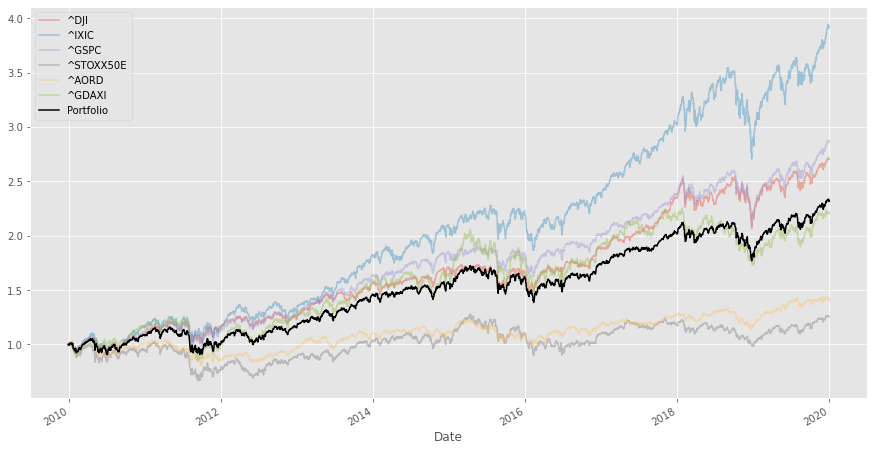

In [7]:
asset_universe.plot(figsize=figsize, alpha=0.4)
portfolio.plot(label='Portfolio', color='black')
plt.legend()
plt.show()

As you would expect the returns end up being somewhere in the middle of the individual returns. In fact as this is an equally weighted portfolio it will by definition end up exactly in the “middle” of the constituent returns.

Let’s now carry out the Bootstrapping process on our portfolio return series and plot the results.

In [8]:
# Before considering the application, study the simplified example below:

ListOfValues=[0,1,2,3,4,5]
NumberOfValuesToChoose=7
HowManyTimesToRepeat=3

pd.DataFrame([random.choices(list(ListOfValues), k=NumberOfValuesToChoose) for i in range(HowManyTimesToRepeat)])

,0,1,2,3,4,5,6
0,5,0,4,3,3,0,4
1,4,2,2,1,5,0,1
2,0,2,2,3,1,0,4


### <font color=red> Approach 1</font>

In [9]:
# Now, apply it to your empirical data
portfolio_bootstrapping = (1+pd.DataFrame([random.choices(list(
    portfolio_returns.values), k=252) for i in 
    range(1000)]).T.shift(1).fillna(0)).cumprod()

portfolio_bootstrapping

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.991612,1.032200,0.986093,1.003327,1.004340,1.012192,0.997105,0.992908,1.013958,0.991265,...,0.985739,0.997945,0.996689,1.013549,1.000345,1.001478,0.996172,0.993817,1.005798,1.001966
2,0.991343,1.028613,0.995227,1.000352,0.997263,1.011631,0.997061,0.994462,1.018332,0.992686,...,0.975882,1.002326,0.998006,1.007929,1.003373,1.002138,0.953481,0.997742,1.010498,1.002586
3,0.984667,1.025103,0.991711,0.999895,0.998824,1.015078,0.991990,1.000431,1.013024,0.993052,...,0.981185,1.009665,0.998091,1.010841,1.004177,1.003378,0.955731,1.002572,1.007501,1.005730
4,0.979994,1.039041,0.996871,1.005917,1.001105,1.015552,0.996052,1.003209,1.024787,0.976719,...,0.987855,0.994889,0.983922,1.003350,1.007324,1.000579,0.963011,1.002074,1.009360,1.012231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.264573,1.423752,0.940187,1.021785,1.189813,1.007712,1.050430,1.094851,1.298135,0.993139,...,1.183160,0.946680,1.032600,1.038789,0.941335,0.808185,1.132486,1.133150,0.894133,0.988781
248,1.267996,1.417846,0.944351,1.020720,1.188043,1.007888,1.051247,1.091295,1.323553,0.999500,...,1.178436,0.950445,1.033343,1.038142,0.940505,0.834949,1.123455,1.132380,0.898972,0.994361
249,1.266754,1.427479,0.943813,1.051887,1.188262,1.007549,1.030920,1.081970,1.296075,0.979688,...,1.178358,0.946127,1.036462,1.038147,0.941452,0.834719,1.117600,1.139695,0.900269,0.989142
250,1.250722,1.393611,0.944007,1.053350,1.191169,1.006050,1.041457,1.080553,1.300927,0.980149,...,1.178595,0.945889,1.023650,1.037350,0.952238,0.841176,1.099611,1.110061,0.899153,0.989866


(0.7, 1.6)

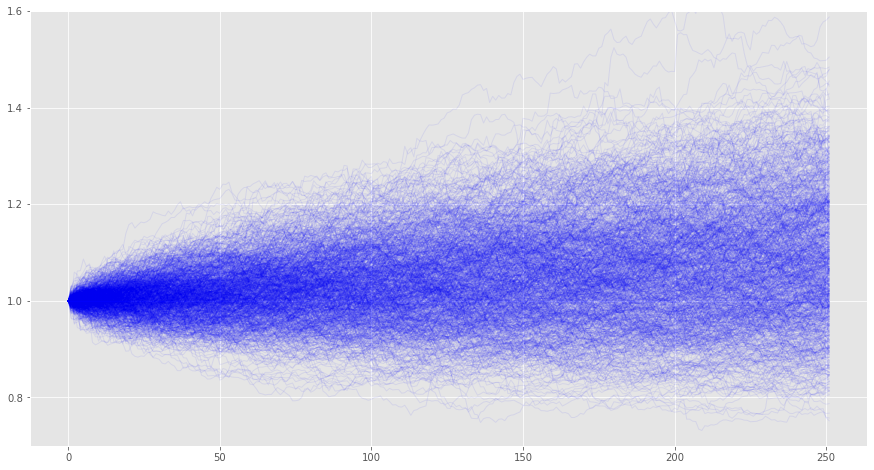

In [12]:
portfolio_bootstrapping.plot(figsize=figsize, legend=False, linewidth=1, alpha=0.07, color='b');
plt.ylim(0.7,1.6) # for comparison, we want to keep the y-axis scale fixed

### <font color=red> Approach 2</font>

And just to prove that approaching it from the other way around is analogous we do that below. We take samples of our individual constituent returns series and use them to create our Bootstrapped simulations. We end with the same result (there or there abouts, of course there is a random element which will make every simulation different even if based on the same approach) – below is the code that achieves that.

In [13]:
asset_universe_returns = asset_universe.pct_change()
portfolio_constituents_bootstrapping = pd.DataFrame([((asset_universe_returns.iloc[random.choices(
    range(len(asset_universe)), k=252)]).mean(axis=1)+1).cumprod().values 
    for x in range(1000)]).T

(0.7, 1.6)

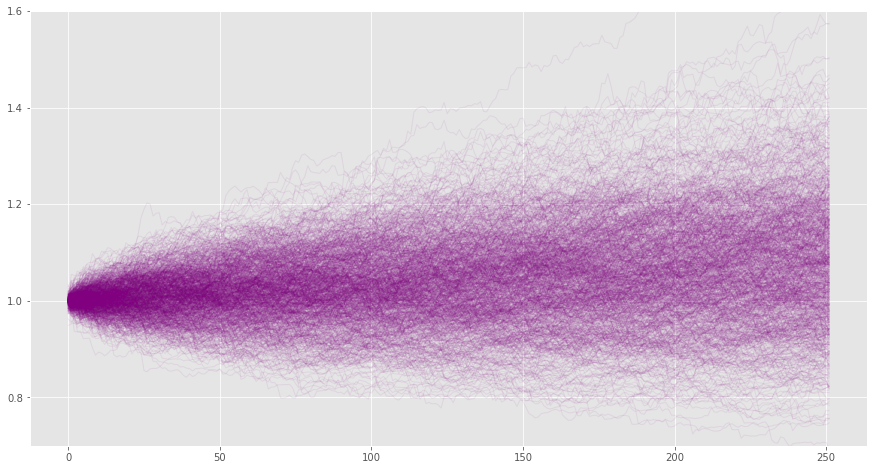

In [14]:
portfolio_constituents_bootstrapping.plot(figsize=figsize, legend=False, linewidth=1, alpha=0.07, color='purple');
plt.ylim(0.7,1.6)

### <font color=red> Approach 3</font>

Finally, we consider the **parametric Monte Carlo method**. After that, we can run a quick comparison between the results of the various approaches.

As previously discussed, the **parametric Monte Carlo method involves using the characteristics of the underlying population to generate random samples** of values. The characteristics we are talking about here are the mean and standard deviation (or variance) of the historic return distribution. These values will then be fed into a model that randomly samples from a normal distribution with mean and standard deviation equal to that of the historic returns.

Let’s extract those figures first for our combined portfolio. We already have the historic return series stored from earlier.

In [15]:
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()
print(f'Our portfolio (annualized) mean return value is {round(mu*100*252,2)}%')
print(f'Our portfolio (annualized) standard deviation value is {round(sigma*100*np.sqrt(252),2)}%')

Our portfolio (annualized) mean return value is 8.29%
Our portfolio (annualized) standard deviation value is 12.7%


Now we generate the necessary draws from the normal distribution with mean and standard deviation we found:

In [16]:
portfolio_mc = pd.DataFrame([(np.random.normal(loc=mu, scale=sigma, size=252)+1) for x in range(1000)]).T.cumprod()

(0.7, 1.6)

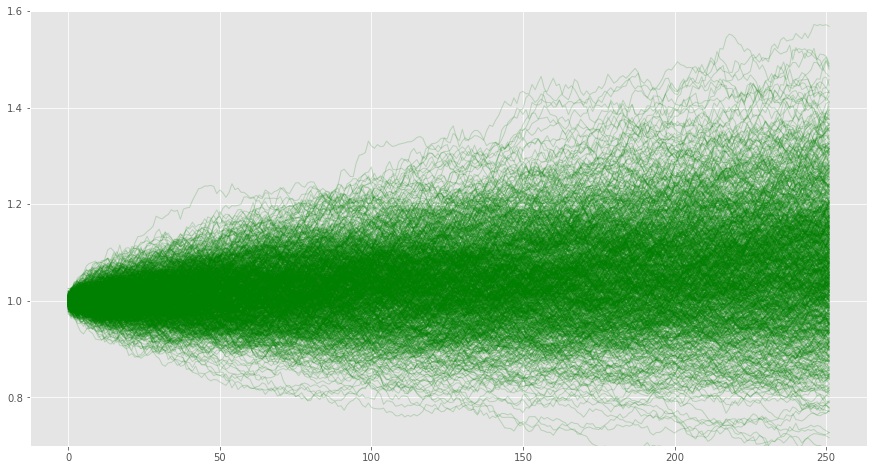

In [17]:
portfolio_mc.plot(figsize=figsize, legend=False, linewidth=1, alpha=0.2, color='green');
plt.ylim(0.7,1.6)

### <font color=red> Approach 4</font>

Now run the Monte Carlo simulation but this time create random draws from each individual asset distribution and then construct our portfolio and see if there is any differences in outcome.

In [18]:
asset_universe_returns.mean()

^DJI         0.000387
^IXIC        0.000534
^GSPC        0.000411
^STOXX50E    0.000149
^AORD        0.000151
^GDAXI       0.000343
dtype: float64

In [19]:
for asset in asset_universe_returns.mean().index:
    print(f'The mean return for {asset} is {(asset_universe_returns.mean() * 100 * 252).round(2)[asset]}%')
    
print()
for asset in asset_universe_returns.mean().index:
    print(f'The mean return for {asset} is {(asset_universe_returns.std() * 100 * np.sqrt(252)).round(2)[asset]}%')
    
# `asset_universe_returns.mean().index` was used to simply extract the column names
print()
print(asset_universe_returns.mean().index)

The mean return for ^DJI is 9.75%
The mean return for ^IXIC is 13.47%
The mean return for ^GSPC is 10.36%
The mean return for ^STOXX50E is 3.76%
The mean return for ^AORD is 3.8%
The mean return for ^GDAXI is 8.63%

The mean return for ^DJI is 13.27%
The mean return for ^IXIC is 16.08%
The mean return for ^GSPC is 13.93%
The mean return for ^STOXX50E is 18.71%
The mean return for ^AORD is 12.53%
The mean return for ^GDAXI is 17.85%

Index(['^DJI', '^IXIC', '^GSPC', '^STOXX50E', '^AORD', '^GDAXI'], dtype='object')


Create our DataFrames of simulated asset returns for each individual asset and store them in a list.

In [20]:
asset_returns_dfs = []
for asset in asset_universe_returns.mean().index:
    mu = asset_universe_returns.mean()[asset]
    sigma = asset_universe_returns.std()[asset]
    asset_mc_rets = pd.DataFrame([(np.random.normal(loc=mu, 
                    scale=sigma, size=252)) for x in range(1000)]).T
    
    asset_returns_dfs.append(asset_mc_rets)

Use list comprehension to iterate through the list of asset return DataFrames and divide the values by the number of assets to represent an equally weighted portfolio.

In [21]:
weighted_asset_returns_dfs = [(returns_df / len(tickers)) for returns_df in asset_returns_dfs]

Add together the DataFrame values using the “reduce” function from the “functools” library (great library by the way, along with the “itertools” library. Loads of great useful functions and definitely worth checking out)

In [22]:
portfolio_constituents_mc = (reduce(lambda x, y: x + y,weighted_asset_returns_dfs) + 1).cumprod()

(0.7, 1.6)

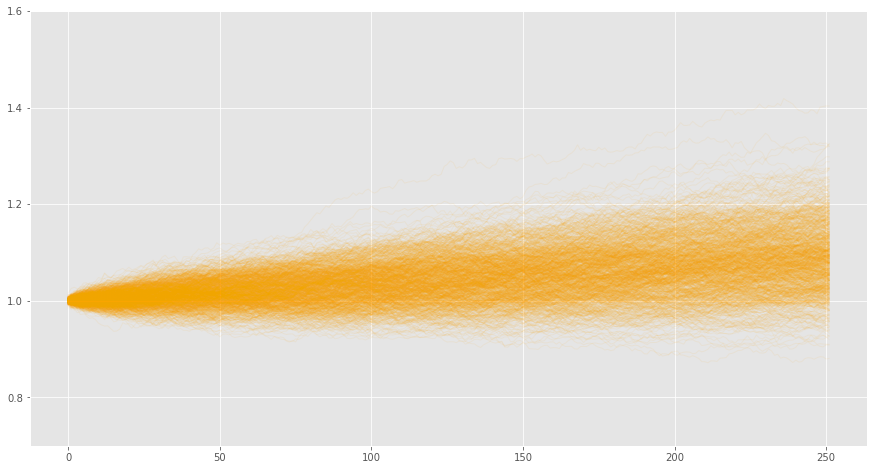

In [23]:
portfolio_constituents_mc.plot(figsize=figsize, legend=False, linewidth=1, alpha=0.07, color='orange');
plt.ylim(0.7,1.6)

***
We can see immediately that something looks different!! Or well, maybe not immediately but something should jump out at us. If you notice, all the previous simulations (whether Bootstrapping or Monte Carlo) have all produced simulations which fall within the ending value bounds of around 0.8 to 1.6. But in the last plot we see these bounds have tightened to around 0.9 to 1.3.

That’s a significant difference, and one that can not be put down to the effects of randomness alone. If you re-run all these simulations a few times, you will see that the outcomes remain similar, and that the last method will pretty much always produce a tighter range of ending values.
> Recall the effects of correlation between individual assets, and the fact that we had to be careful to capture this effect when running our simulations? It is only the last method which fails to capture this effect of correlation.

Let’s take a quick look at the historic correlations between the constituent assets’ returns in the “asset universe” we chose.
> Note: Calculate the correlation between the asset’s returns, **NOT** their prices.

[]

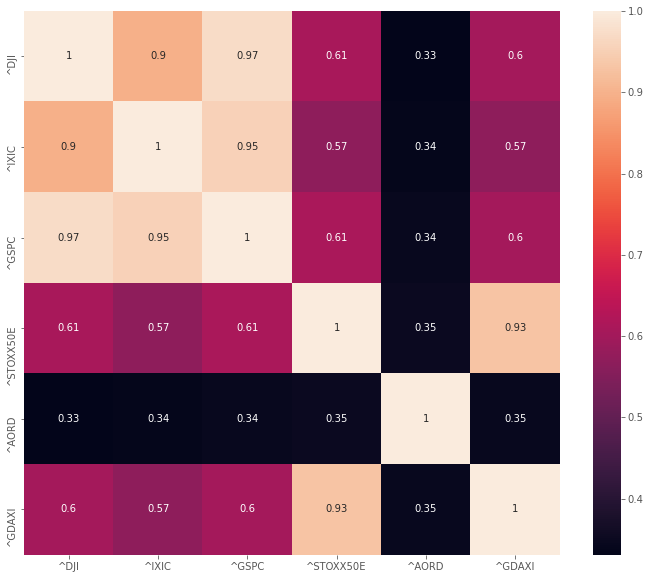

In [24]:
ax, fig = plt.subplots(figsize=(12,10))
sns.heatmap(asset_universe_returns.corr(),annot=True)
plt.plot()

Looking at the above values, observe that all of the assets are positively correlated to some degree but, more importantly, all the values are positive. This explains why our last plot and out last simulation method (the parametric Monte Carlo simulations on constituent assets that were then weighted and summed to represent our portfolio) resulted in a more narrow range of end values (these end values are often referred to as **Terminal Wealth** of a portfolio).

The logic is reasonably simple:
- When two assets are correlated, they tend to move in the same direction at the same time.
- If one experiences a rise in value, generally so does the other. 
- This results in portfolios which contain positively correlated assets.
- Because all constituent assets are highly correlated, they will all tend to move up and down at the same time, causing more volatile swings in portfolio value.

So how does this relate to our situation and why is it the cause of the difference in outcomes in the last model?

- The first 3 approaches all captured the inherent correlation that exists between the constituent assets, whereas our last approach did not.
- Approach 1 created our portfolio using real historic daily return values that were actually seen to happen in the markets on the same day – so the moves that were incorporated were real moves that were generated by the underlying process that accounted for and was affected by the existing correlation structure between the assets.
- Same logic in Approach 2 – although we Bootstrapped returns for our individual assets this time and THEN formed our portfolio, the initial returns that were Bootstrapped were again carefully selected so that all returns in a single draw were taken from the same day for each asset. That again made sure that the values we were extracting were real values that actually took place on a single day for **all** constituents, and again were generated by the real underlying process which implicitly accounts for the correlation structure between the assets.

Now it becomes slightly more subtle as to the difference for approach 3 and 4.

- With Approach 3, we created our portfolio using real individual asset returns and THEN ran the parametric Bootstrap process, simulating return series based on the underlying characteristics of the portfolio. Now here is the important part: Because the portfolio was FIRST created by using real values of weighted daily returns of individual assets, the price series implicitly accounted for the correlation between the assets. THEN, when we ran the Monte Carlo simulation, it was being fed input parameters that were calculated based on historic price series that had those correlations implicitly built in. So that method DID capture the effects of correlation.
- However, in Approach 4 we failed to model the effect of correlation correctly. The individual Monte Carlo simulations for each asset were being fed with parameters that were calculated based on calculated values that were completely independent of each other.
- In Approach 4, the calculation for the mean and standard deviation of one asset, was being done in a “vacuum” as it were, in a way that was completely independent from the other assets. With the draws then being made from a normal distribution meant that the individual values drawn on each day for each asset were indeed “random” – that is to to say there was an equal chance that the outcome could be positive or negative for each individual asset, regardless of the output for the other assets.

Well this sounds very much like what we would expect from a series of completely uncorrelated assets – for each to move randomly, irrespective of the moves of the others. So suddenly, in Approach 4, we had begun to model the simulated prices series of a basket of uncorrelated assets! That is not what we wanted to do. 

Be careful when carrying out these approaches and make sure you are correctly modelling what you are actually trying to model!